# Libraries

In [54]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, anderson

# Load Data

In [ ]:
filepath = "../data/"

train_df = pd.read_parquet(filepath+"train.parquet")
# test_df = pd.read_parquet(filepath+"test.parquet")

In [18]:
print("Missing values in 'label':", train_df['label'].isna().sum())

if isinstance(train_df.index, pd.DatetimeIndex):
    is_sorted = train_df.index.is_monotonic_increasing
    is_unique = train_df.index.is_unique
    print(f"Index is datetime: True | Sorted: {is_sorted} | Unique: {is_unique}")
else:
    print("Index is not a DatetimeIndex.")

Missing values in 'label': 0
Index is datetime: True | Sorted: True | Unique: True


# Target Distribution Analysis

## Descriptive Statistics  
- The target variable is relatively centered around zero, with a mean of **0.03**, indicating low bias prior to standardization. However, the standard deviation of approximately **1.0** reflects substantial dispersion.  
- This contrast is especially apparent when compared to the **narrow 95% confidence interval for the mean**, indicating that the overall distribution must be highly variable.  
- The **minimum and maximum values of -24 and 20**, respectively, further underscore the presence of extreme values and heavy tails. This pattern is consistent with a distribution closer to a **Student's t** or even **Cauchy**, rather than a standard Gaussian.

In [37]:
mean = train_df['label'].mean()
median = train_df['label'].median()
skew = train_df['label'].skew()
std = train_df['label'].std()

print(f"Target Mean: {mean}")
print(f"Target Median: {median}")
print(f"Target Standard Deviation: {std}")
print(f"Target Skew: {skew}")

z = 1.96  # or use t-score if n is small
stderr = std / np.sqrt(len(train_df))
ci_lower = mean - z * stderr
ci_upper = mean + z * stderr

print(f"95% CI for Mean (Assuming Normality): [{ci_lower:.4f}, {ci_upper:.4f}]")

train_df['label'].describe()

Target Mean: 0.03612583479917426
Target Median: 0.016260691207415537
Target Standard Deviation: 1.0099145156502942
Target Skew: -0.11348704299677286
95% CI for Mean (Assuming Normality): [0.0334, 0.0389]


count    525886.000000
mean          0.036126
std           1.009915
min         -24.416615
25%          -0.381586
50%           0.016261
75%           0.434137
max          20.740270
Name: label, dtype: float64

## Initial Plots  
- The boxplots, histograms, and KDE plots reflect the same key trends observed in the descriptive statistics: a strong concentration of values around **0** and the **mean**, but with a significant number of extreme outliers.  
- Even in the **clipped plots**, we see that the measures of dispersion (e.g., mean, median, standard deviation) remain tightly clustered near the center, reinforcing the idea of a central tendency surrounded by heavy tails.  
- The histogram and KDE also suggest **non-normality**, with tails that extend far beyond what would be expected under a Gaussian distribution—consistent with the earlier observation that the data may be better modeled by a **heavy-tailed distribution**.

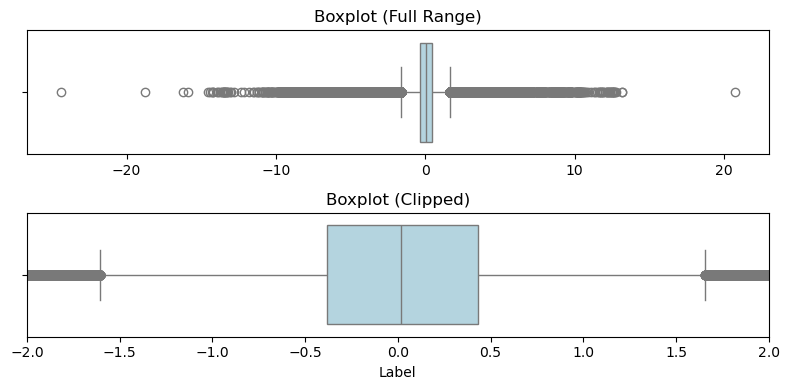

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(2, 1, 1)
sns.boxplot(x=train_df['label'], color='lightblue')
plt.title("Boxplot (Full Range)")
plt.xlabel("")

plt.subplot(2, 1, 2)
sns.boxplot(x=train_df['label'], color='lightblue')
plt.xlim(-2, 2)
plt.title("Boxplot (Clipped)")
plt.xlabel("Label")

plt.tight_layout()
plt.show()


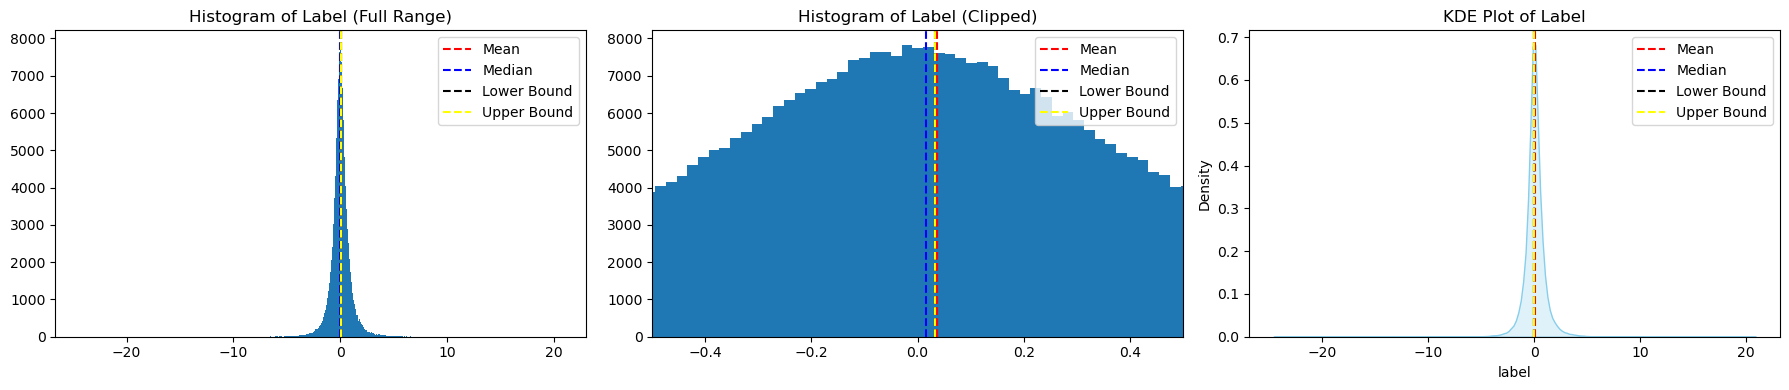

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(train_df['label'], bins='auto')
axes[0].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[0].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[0].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[0].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[0].set_title("Histogram of Label (Full Range)")
axes[0].legend()

axes[1].hist(train_df['label'], bins='auto')
axes[1].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[1].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[1].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[1].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[1].set_xlim(-0.5, 0.5)
axes[1].set_title("Histogram of Label (Clipped)")
axes[1].legend()

sns.kdeplot(train_df['label'], ax=axes[2], fill=True, color='skyblue')
axes[2].axvline(x=mean, color='red', linestyle='--', label='Mean')
axes[2].axvline(x=median, color='blue', linestyle='--', label='Median')
axes[2].axvline(x=ci_lower, color='black', linestyle='--', label='Lower Bound')
axes[2].axvline(x=ci_lower, color='yellow', linestyle='--', label='Upper Bound')
axes[2].set_title("KDE Plot of Label")
axes[2].legend()

plt.tight_layout()
plt.show()

## Distribution Analysis

## Normality Analysis

- Formal normality tests (Shapiro-Wilk, D’Agostino’s K², and Anderson-Darling) yield p-values well above typical thresholds (e.g., 0.05). However, due to the extremely large sample size (~500,000), these results may not be reliable—the tests can become overly sensitive or inaccurate at this scale.
- Despite high p-values, visual evidence from the Q-Q plot strongly suggests **non-normality**. We observe heavy tails and slight skewness, consistent with the descriptive statistics and histograms.
- Taken together, these indicators point toward a **departure from Gaussian behavior**, likely driven by outliers, kurtosis, and potential skew. This may be suggesting a distribution more aligned with heavy-tailed families like the Student-t or Cauchy.

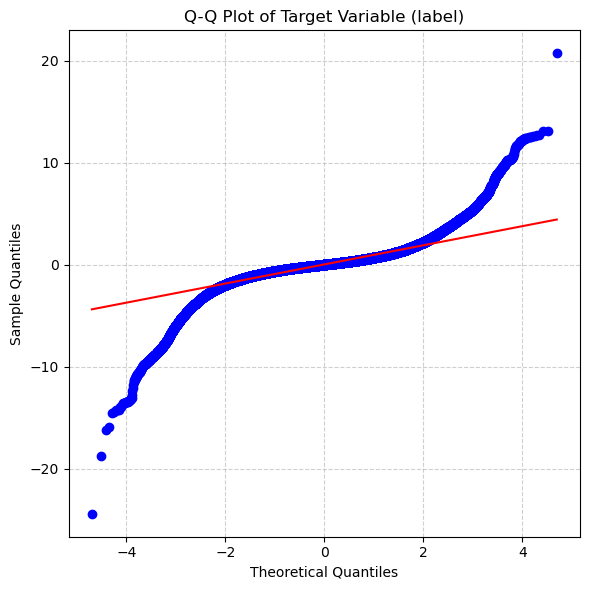

Shapiro-Wilk Test:      stat = 0.8627, p-value = 0.0000e+00
D’Agostino-Pearson Test: stat = 116907.3714, p-value = 0.0000e+00
Anderson-Darling Test:   stat = 14013.8673
  15% level: crit = 0.5760 → Reject H0
  10% level: crit = 0.6560 → Reject H0
  5% level: crit = 0.7870 → Reject H0
  2% level: crit = 0.9180 → Reject H0
  1% level: crit = 1.0920 → Reject H0


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [55]:
plt.figure(figsize=(6, 6))
stats.probplot(train_df['label'], dist="norm", plot=plt)

plt.title("Q-Q Plot of Target Variable (label)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

shapiro_stat, shapiro_p = shapiro(train_df['label'])
print(f"Shapiro-Wilk Test:      stat = {shapiro_stat:.4f}, p-value = {shapiro_p:.4e}")
dagostino_stat, dagostino_p = normaltest(train_df['label'])
print(f"D’Agostino-Pearson Test: stat = {dagostino_stat:.4f}, p-value = {dagostino_p:.4e}")
anderson_result = anderson(train_df['label'], dist='norm')
print(f"Anderson-Darling Test:   stat = {anderson_result.statistic:.4f}")
for i in range(len(anderson_result.critical_values)):
    cv = anderson_result.critical_values[i]
    sl = anderson_result.significance_level[i]
    result = "Reject" if anderson_result.statistic > cv else "Fail to Reject"
    print(f"  {sl:.0f}% level: crit = {cv:.4f} → {result} H0")

## Distribution Testing

# Regime Exploration

# Reverse Classification + Modeling

# Outlier Analysis

# Feature Engineering from Regimes and Anomalies

# Summary + Next Steps